# Pryngles module: rings

In [2]:
from pryngles import *
sci=Science

## External modules

In [3]:
import spiceypy as spy
import math as mh
import numpy as np
import copy

## Ring default properties

In [4]:
class RingDefaults(object):
    """
    These are the default attributes for bodies of the kind 'Ring'.
    
    DEVELOPER:
        You may add new attributes as the model gets more complex.
        Please document properly each attribute.
        
    orbit:
    
        (In current version, Ring body does not have orbit attributes)
        
    physics:
    
        fi: float [adimensional], default = 1:
            Fraction of the radius of the primary object where ring stars.
            
        fe: float [adimensional], default = 1:
            Fraction of the radius of the primary object where ring ends.
            
        i: float [radians], default = 0:
            Inclination of the ring with respect to the equator of the primary
            object.
            
        roll: float [radians], default = 0:
            Roll angle.  This is the angle with respect to ecliptic x-axis in which 
            the normal to the ring plane is rotated.
            
    optics:
    
        nspangles: int, default = 1000: 
            Number of spangles on which the object will be discretized.
            
        albedo_gray_normal: float. default = 1: 
            Lambertian (normal) gray (wavelength indpendent) albedo of the spangle.
            
        tau_gray_optical: float. default = 0:
            Gray (wavelength indpendent) Optical depth of the spangle.  
            If 0 the spangle is entirely opaque to all wavelength, despite its type.            
    """
    orbit=dict()
    
    physics=dict(fi=1.0,fe=2.0,i=0.0,roll=0.0)
    
    optics=dict(nspangles=1000,
                albedo_gray_normal=1,
                tau_gray_optical=0
               )

## Ring Class

In [5]:
BODY_KINDS+=["Ring"]

class Ring(Body):
    """Class Planet.
    
    See Body class documentation.
    
    Additional public attributes:
    
        ri: float [rlu]:
            Radius of the inner border of the ring

        re: float [rlu]:
            Radius of the outer border of the ring
            
        spangles: list of Spangle objects:
            List of spangles covering the surface (for spangle options see Spangle documentation)
    
    Override methods:
    
        update_body(**pars):
            This method compute additional attributes like (see above).
    """
    def __init__(self,
                 primary=None,
                 orbit=RingDefaults.orbit,
                 physics=RingDefaults.physics,
                 optics=RingDefaults.optics
                ):
        
        
        #Instantiate object with basic properties
        Body.__init__(self,RingDefaults,"Ring",primary,orbit,physics,optics)
        
        #Check primary
        if self.primary is None:
            raise ValueError(f"Primary not provided and mandatory for {self.kind}.")
        #self.primary=primary
        #self.primary._update_childs(self)
        #self._update_parent(self.primary)
        
        #Update properties
        self.update_body(**self.__dict__)
        
    def _set_transform(self):
        """
        Set transformation matrices
        """
        #Normal vector to ring
        self.nr_ecl=np.array([0,mh.sin(self.physics.i),mh.cos(self.physics.i)]) 
        self.nr_equ=np.array([0,0,1]) 
        
        #Build transformation matrices
        ex_equ=np.array([1,0,0]) 
        ey_equ=np.array([0,mh.cos(self.physics.i),-mh.sin(self.physics.i)])
        ez_equ=self.nr_ecl
        self.M_equ2ecl=np.array(list(np.vstack((ex_equ,ey_equ,ez_equ)).transpose())).reshape((3,3))
        self.M_ecl2equ=spy.invert(self.M_equ2ecl)

In [6]:
if IN_JUPYTER:
    def test_init(self):
        
        #Define first star and planet
        S=Star()
        P=Planet(primary=S)

        self.assertRaises(ValueError,lambda:Ring())
        R=Ring(primary=P)
        
        print(R.physics)
        print(R.optics)
        print(R.hash)
        
    class Test(unittest.TestCase):pass    
    Test.test_init=test_init
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'fi': 1.0, 'fe': 2.0, 'i': 0.0, 'roll': 0.0}
{'nspangles': 1000, 'albedo_gray_normal': 1, 'tau_gray_optical': 0}
8761241784857



----------------------------------------------------------------------
Ran 1 test in 0.001s

OK


### Update body

In [7]:
def update_body(self,**pars):
    Body.update_body(self,**pars)

    #Here place the commands to update this kind of body
    self.ri=self.physics.fi*self.primary.physics.radius
    self.re=self.physics.fe*self.primary.physics.radius

    #Set transformation matrices
    self._set_transform()

Ring.update_body=update_body

In [8]:
if IN_JUPYTER:
    def test_update(self):

        #Define first star and planet
        S=Star()
        P=Planet(primary=S)
        R=Ring(primary=P)
        
        R.update_body(physics=dict(fe=3))
        print(R.physics)
        
        #Check derived properties
        print(R.M_equ2ecl)
        print(R.M_ecl2equ)
        print(R.nr_ecl)
        print(R.nr_equ)
        
    class Test(unittest.TestCase):pass    
    Test.test_update=test_update
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

.

{'fi': 1.0, 'fe': 3, 'i': 0.0, 'roll': 0.0}
[[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0. -0.  1.]]
[[ 1. -0.  0.]
 [-0.  1. -0.]
 [-0.  0.  1.]]
[0. 0. 1.]
[0 0 1]



----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


### Spangle body

This method creates the spangles taht will cover the body.

In [92]:
def spangle_body(self,seed=0):
    #Create spangler
    self.sp=Spangler(N=self.optics.nspangles)
    
    #Limits of the ring (normalized to re)
    uri=self.ri/self.re
    ure=1
    
    #Generate spangles
    self.sp.gen_ring([
        [0.0,uri],#Internal gap
    ],boundary=0)
    
    #Purge to avoid close-in spangles
    self.sp.purge_sample()
    
    #Generate spangle properties
    self.spangles=np.array([],dtype=Spangle)
    for i in range(self.sp.N):

        #Create spangle
        spangle=Spangle()
        
        #Type of spangles
        spangle.type=GRANULAR_SPANGLE
        
        #Coordinates of the spangle
        xyz_equ=np.append(self.sp.ss[i]*self.re,0) #Complete coordinates with z = 0
        xyz_ecl=spy.mxv(self.M_equ2ecl,xyz_equ) #Rotate to ecliptic coordinates
        
        rqf_equ=np.append(self.sp.pp[i],0) #Complete coordinates with phi = 0
        rqf_equ[0]*=self.re #Scale radial coordinate
        rqf_ecl=sci.xyz2rqf(xyz_ecl) #Convert equatorial to spherical
        
        spangle.set_position([xyz_equ,xyz_ecl],[rqf_equ,rqf_ecl])

        #Unitary vector normal to the spangle
        ns_equ=np.array([0,0,1])
        ns_ecl=spy.mxv(self.M_equ2ecl,ns_equ)
        spangle.set_orientation([ns_equ,ns_ecl])
            
        #Spangle Area
        spangle.asp=self.sp.aes*self.re**2
        
        #Optical properties
        spangle.set_optical(
            albedo_gray_normal=self.optics.albedo_gray_normal,
            tau_gray_optical=self.optics.tau_gray_optical
        )
        
        self.spangles=np.append(self.spangles,copy.deepcopy(spangle))
        del spangle

Ring.spangle_body=spangle_body

1172
{'nspangles': 1000, 'albedo_gray_normal': 1, 'tau_gray_optical': 0}
[array([-0.72225212,  0.69186132,  0.        ]), array([-0.72225212,  0.69186132,  0.        ])]


<IPython.core.display.Javascript object>


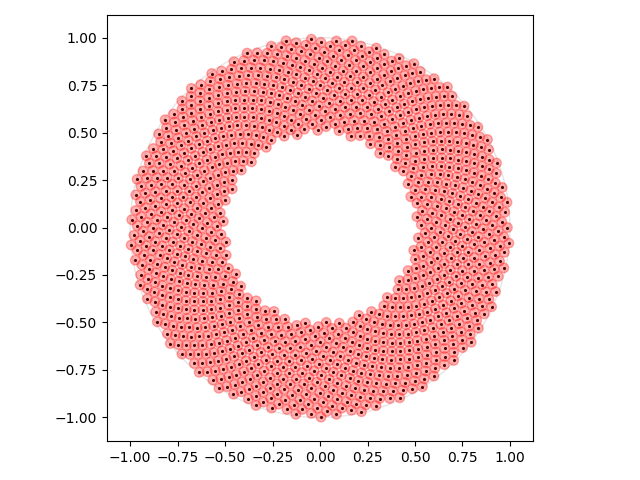

.

0.0020104048551129222
0.008041619420451689



----------------------------------------------------------------------
Ran 1 test in 0.902s

OK


In [93]:
if IN_JUPYTER:
    def test_spangle(self):
        S=Star()
        P=Planet(primary=S)
        R=Ring(primary=P)  
        R.spangle_body()
        print(R.sp.N)
        print(R.optics)
        print(R.spangles[0].xyz)
        
        #return
        #"""
        spangled=None
        spangled=dict(color='r')
        R.sp.plot(spangled=spangled)
        #"""
        #print(len(R.spangles))
        print(R.sp.aes)
        print(R.spangles[0].asp)
        
    class Test(unittest.TestCase):pass    
    Test.test_spangle=test_spangle
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [25]:
#Trasnform from observer to other system
"""
    self.eobs_ecl=eobs_ecl
    self.nobs_ecl=spy.latrec(1,self.eobs_ecl[0],self.eobs_ecl[1])
    self.nobs_equ=spy.mxv(self.M_ecl2equ,self.nobs_ecl)
    self.eobs_equ=np.array(Util.transformRecLat(self.nobs_equ))
    #Build transformation matrices
    self.M_ecl2obs=spy.mxm(
        spy.rotate(+(mh.pi/2-self.eobs_ecl[1]),1),
        spy.rotate(np.mod(self.eobs_ecl[0]+np.pi/2,2*mh.pi),3)
    )
    self.M_obs2ecl=spy.invert(self.M_ecl2obs)
    #Observer<->Equatorial
    self.M_equ2obs=spy.mxm(self.M_ecl2obs,self.M_equ2ecl)
    self.M_obs2equ=spy.invert(self.M_equ2obs)
""";

In [54]:
def plot_body(self,
              observer=(1,0*Const.deg,90*Const.deg),
              source=(1,0,0)):
    """
    Plot spangle positions from the vantage point of an observer located at (lamb_obs,beta_obs)
    in the ecliptic reference frame.
    
    Parameters:
    
        observer: array (3) [rad], default = (1,0 deg, 90 deg):
            Ecliptic coordinates of the observer (lambda, beta) or longitud and latitude.
            beta = 90 deg sets the observer above the plane of the ecliptic.
            
        ilumination: array (3) [rad], default = (1,0,0):
            Location of the source of light for test purposes.
            
    """
    fig,ax=plt.subplots(1,figsize=(5,5))
    fig.patch.set_facecolor("black")
    
    #ax.scatter(self.spangles[:].xyz[ECL][0],self.spangles[:].xyz[ECL][1],c='w',s=0.5)
    ax.scatter(self.sp.ss[:,0],self.sp.ss[:,1],c='w',s=2,marker='o')
    """
    for i in range(self.sp.N):
        #Transform coordinates of the spangle to observer
        ax.scatter(self.spangles[i].xyz[ECL][0],self.spangles[i].xyz[ECL][1],c='w')
    """
    
    ax.axis("off")

Ring.plot_body=plot_body

<IPython.core.display.Javascript object>


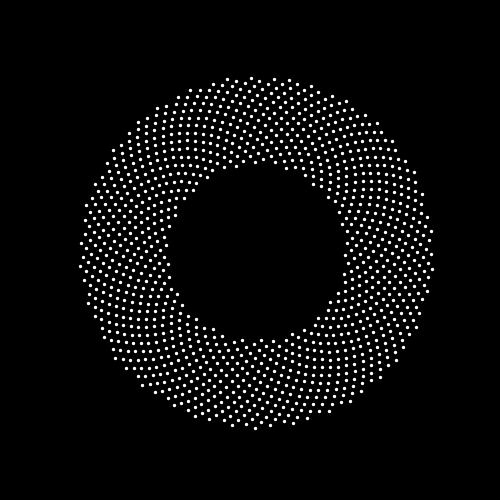

.
----------------------------------------------------------------------
Ran 1 test in 0.289s

OK


In [55]:
if IN_JUPYTER:
    def test_plot(self):
        S=Star()
        P=Planet(primary=S)
        R=Ring(primary=P)  
        R.spangle_body()
        R.plot_body()
        
    class Test(unittest.TestCase):pass    
    Test.test_plot=test_plot
    unittest.main(argv=['first-arg-is-ignored'],exit=False)

In [56]:
import pandas as pd

In [114]:
df=pd.DataFrame(columns=["name",
                         "x_equ","y_equ","z_equ","function","xyz_equ"])

In [115]:
df=df.append(dict(name="sin",function=np.sin),ignore_index=True)

In [120]:
df.loc[0].function=np.cos
df.loc[0][["x_equ","y_equ","z_equ"]]=np.array([1,2,3])
df.loc[0,"xyz_equ"]=[1,2,3]

In [121]:
df

,name,x_equ,y_equ,z_equ,function,xyz_equ
0,sin,1,2,3,<ufunc 'cos'>,"[1, 2, 3]"


In [125]:
df.loc[0,"xyz_equ"][:1]

[1]

--End--